# THIS IS THE SOLUTION FOR COMPUTATIONAL INTELLIGENS LAB 01

> Author: `Daniel Bologna - s310582`
> - You can find the solution below.

Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [25]:
from random import random, seed
from itertools import product
import numpy as np

from icecream import ic

# EXTRA LIBRARIES (!plot ONLY purpose!)
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from itertools import accumulate

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [26]:
UNIVERSE_SIZE = 10_000
NUM_SETS = 1_000
DENSITY = 0.2

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [27]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [28]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## Have Fun!

In [29]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
valid(solution), cost(solution)

(np.True_, np.float64(4270633.790347424))

In [30]:
# A random solution with random 50% of the sets
solution = rng.random(NUM_SETS) < .5
valid(solution), cost(solution)

(np.True_, np.float64(2133773.7617388084))

---

# Solution

## Implementation

### Utility functions

In [31]:
def clamp(_min, _max, _val):
    return max(_min, min(_max, _val))

### Validity function

I've choosen the same one provided during the lab

In [32]:
def valid(_current_solution : np.ndarray) -> bool:
    """
    Checks wether solution is valid (ie. covers all universe)
    Args:
        _current_solution (np.ndarray): The current solution.
    Returns:
        bool: _current_solution validity.
    """
    return np.all(np.logical_or.reduce(SETS[_current_solution]))

### Cost function

Our goal is to minimize the cost of finding the smallest union of subsets S that covers the universe U. To do this, we must think of a fitness function that, when maximized, also minimizes the cost. We can also think to consider not only the cost as defined earlier but to re-think it as the number of subsets in our current solution.


Starting from the `cost function`, we can see that it computes the sum of the cost of each selected subset in our current solution.
- the **cost of a single subset** is *the count of taken element of the universe to the power of 1.1*. 
- the **cost of a solution** is the sum of the costs of each subset inlcuded in the solution itself.

we can tell that if the cost of a solution is around pow(UNIVERSE_SIZE, 1.1) we can expect aving the right amount of element **without knowing if these elements actually cover the universe**.

In the end we can re-think the cost function as the count of **how many times universe's elements are chosen in different subsets**. In this way, we want to minimize this overlapping value.

In [33]:
def alternative_cost_function(_current_solution : np.ndarray) -> int:
    intersection = np.add.reduce(SETS[_current_solution])
    cost = 0
    for x in intersection:
        if x > 1:
            cost += x - 1
    return cost

### Fitness function

See the fitness as the tuple containing the following values

- valid(solution)
- number of chosen universe's element taken once
- -cost(solution)

> Our objective is to maximize the number of elements in the universe covered by our subsets, and minimize the -cost to reduce the intersections (element taken more than once in different subsets).

In [34]:
def fitness(_current_solution : np.ndarray) -> tuple[bool, float, float]:
    return (
        valid(_current_solution), 
        np.logical_or.reduce(SETS[_current_solution]).sum(), 
        -cost(_current_solution))

Let's check some values

In [35]:
cur_sol = rng.random(NUM_SETS) < .3
next_sol = rng.random(NUM_SETS) < .3
is_greater = fitness(next_sol) > fitness(cur_sol) 

ic(fitness(next_sol), fitness(cur_sol), is_greater)

ic| fitness(next_sol): (np.True_, np.int64(10000), np.float64(-1244630.9946361822))
    fitness(cur_sol): (np.True_, np.int64(10000), np.float64(

-1183377.1876428034))
    is_greater: np.False_


((np.True_, np.int64(10000), np.float64(-1244630.9946361822)),
 (np.True_, np.int64(10000), np.float64(-1183377.1876428034)),
 np.False_)

### Tweak function

In [36]:
def tweak(_current_solution : np.ndarray, step_size : float) -> np.ndarray:
    # mask = rng.random(NUM_SETS) < step_size
    # new_solution = np.logical_xor(mask, _current_solution)
    # return new_solution
    new_solution = _current_solution.copy()
    index = None
    while index is None or np.random.random() < step_size:
        index = np.random.randint(0, NUM_SETS)
        new_solution[index] = not new_solution[index]
    return new_solution

### Initial values

In [43]:
MAX_STEPS : int = 10_000

STEP_DEC : float = 0.9
STEP_INC : float = 2.0
STEP_THRESHOLD : int = 500

starting_step_size : float = 0.9

starting_solution : np.ndarray = rng.random(NUM_SETS) < starting_step_size

### Iterations

In [38]:
# current_step_size = starting_step_size
# current_solution = starting_solution.copy()
# current_fit = fitness(current_solution)
# history = [current_fit[1]]

# for i in range(MAX_STEPS):
#     new_solution = tweak(current_solution, current_step_size).copy()
#     new_fit = fitness(new_solution)
#     history.append(new_fit[1])
#     if (new_fit > current_fit):
#         current_solution = new_solution.copy()
#         current_fit = new_fit
#         current_step_size *= STEP_DEC
#         current_step_size = clamp(0.0, 0.99, current_step_size)
#         steps_count = 0
#         ic(current_fit)
#     else:
#         steps_count += 1
#         if steps_count > STEP_THRESHOLD:
#             # worsen the solution            
#             steps_count = 0
#             current_step_size *= STEP_INC

#             # if current_step_size >= 1.0:
#             #     break
#             # if new_fit[2] - current_fit[2] < 0.00001:
#             #    break
        
#             #current_solution = new_solution.copy()
#             #current_fit = new_fit
            
#             #current_step_size += 0.05
#             # if current_step_size >= starting_step_size:
#             #     #current_solution = new_solution.copy()
#             #     #current_fit = new_fit
                


# num_taken_sets = len(SETS[current_solution])
# percentage = str(num_taken_sets / NUM_SETS * 100) + "%"
# iterations = len(history) - 1
# valid(current_solution), NUM_SETS, num_taken_sets, percentage, iterations

In [44]:
def iterate(_starting_solution : np.ndarray, _starting_step_size : float, _step_inc : float, _step_dec : float) -> tuple[np.ndarray, np.ndarray]:
    """
    Checks wether solution is valid (ie. covers all universe)
    Args:
        _starting_solution (np.ndarray): The starting solution.
        _starting_step_size (float): Searching range dimension [0, 1].
        _step_inc (float): How much the searching range will decrese.
        _step_dec (float): How much the searching range will increase.
    Returns:
        (np.ndarray,np.ndarray): returns the final solution and the history to plot the iterations.
    """
    current_step_size = _starting_step_size
    current_solution = _starting_solution.copy()
    current_fit = fitness(current_solution)
    history = [current_fit[2]]
    steps_count = 0

    for i in range(MAX_STEPS):
        # find a new solution nearby our current solution 
        new_solution = tweak(current_solution, current_step_size).copy()
        new_fit = fitness(new_solution)
        history.append(new_fit[2])

        # check if the new solution has a better fitness than the current one
        if new_fit > current_fit:
            # save the new solution as the current one
            current_solution = new_solution
            current_fit = new_fit

            # EXPOLITATION
            # every time we hit a better soluton, narrow the searching range
            current_step_size *= _step_dec
            steps_count = 0
            ic(current_fit[2])
        else:
            # count how many time the solution doesn't change.
            steps_count += 1

            if steps_count > STEP_THRESHOLD:
                # EXPLORATION
                # we spent too much time in the same spot without changing. So try widening the searching range
                current_step_size *= _step_inc
                steps_count = 0

                # ANNEALING
                # if the step size is grown too much accept worsening the solution to change perspective
                if current_step_size > starting_step_size:
                    current_solution = new_solution
                    current_fit = new_fit
    
    # return the final solution and the history 
    return (current_solution, history)

final_solution, history = iterate(starting_solution, starting_step_size, STEP_INC, STEP_DEC)

ic| current_fit[2]: np.float64(-3859569.58887586)
ic| current_fit[2]: np.float64(-3838007.545917608)
ic| current_fit[2]: np.float64(-3833845.728759692)
ic| current_fit[2]: np.float64(-3821554.955389077)
ic| current_fit[2]: np.float64(-3804249.4947253293)
ic| current_fit[2]: np.float64(-3799798.166413459)
ic| current_fit[2]: np.float64(-3795608.1827511257)
ic| current_fit[2]: np.float64(-3778203.448831179)
ic| current_fit[2]: np.float64(-3773940.6222089417)
ic| current_fit[2]: np.float64(-3765382.0237300294)
ic| current_fit[2]: np.float64(-3761126.2514052596)
ic| current_fit[2]: np.float64(-3756980.856716344)
ic| current_fit[2]: np.float64(-3748535.071611154)
ic| current_fit[2]: np.float64(-3744119.1436365256)
ic| current_fit[2]: np.float64(-3739830.442186865)
ic| current_fit[2]: np.float64(-3735492.303967729)
ic| current_fit[2]: np.float64(-3731396.14113445)
ic| current_fit[2]: np.float64(-3718713.1830594973)
ic| current_fit[2]: np.float64(-3714556.05863777)
ic| current_fit[2]: np.floa

In [45]:
# Print al the information about the final solution
num_taken_sets = len(SETS[final_solution])
percentage = str(num_taken_sets / NUM_SETS * 100) + "%"
iterations = len(history) - 1
valid(final_solution), NUM_SETS, num_taken_sets, percentage, iterations

(np.True_, 1000, 29, '2.9000000000000004%', 10000)

### Plot

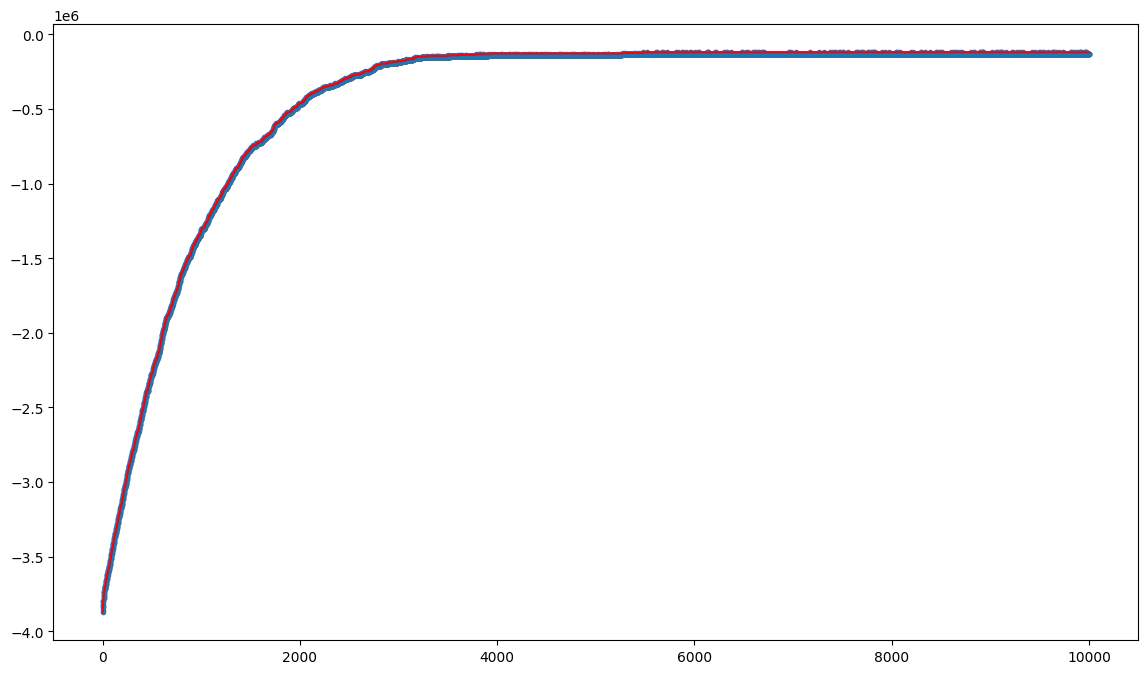

In [46]:
# PLOT !!
plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

## Results!

| instance | Universe size | numset   | density | time   | best result        | worst result       | 
|----------|---------------|----------|---------|--------|--------------------|--------------------|
| 1        | 100           | 10       | 0.2     | 0s     | 9/10 (90%)         | 10/10 (100%)       |
| 2        | 1000          | 100      | 0.2     | 2s     | 18/100 (18%)       | 21/100 (21%)       |
| 3        | 10000         | 1000     | 0.2     | 14.3s  | 28/10000 (2.8%)    | 32/10000 (3.2%)    |
| 4        |               |          |         |        |                    |                    |
| 5        |               |          |         |        |                    |                    |
| 6        |               |          |         |        |                    |                    |

## CREDITS

- Professor's solution from lecture 04/10/2024
- Knapsack problem form lecture ----
- 1-max and 2-max problems from lecture ----